In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import visdom

In [73]:
torch.cuda.is_available()

True

### Erzeuge W

Generiere ein paar W aus $L_{2,loc}$ und ihre Ableitungen

In [74]:
x = np.arange(-5,5,0.001)
dx = x[1] - x[0]

In [75]:
def Gauss(mu, sig, x): #Achtung, hier ist x eine Position, nicht das Grid (ist doch eh das selbe?)
    return np.exp(-(x-mu)**2/(2*sig**2))/(2*np.pi*sig**2)

In [76]:
def generate_W(x):
    rate = 0.01 #das brauchen wir garnicht oder?
    ran = np.zeros(len(x))
    asym = int(len(ran)/4)
    for i in range(asym, len(ran) - asym):
        coin = np.random.uniform()
        if coin < 0.3:
            ran[i] = np.random.uniform() / (0.4 *asym)
    con = np.convolve(ran, Gauss(0,0.1,x)) + 1
    a = int(len(x)/2)
    return con[a:a+len(x)]

In [77]:
def diff_W(W):
    dW = np.zeros(len(W))
    dW[:-1] = np.diff(W)/dx
    return dW

### Berechne $n_r$ und $n_i$

In [78]:
k = 10

In [79]:
def n_r(W, dW, x, k):
    n_r = np.zeros(len(x))
    for i in range(len(x)):
        n_r[i] = W[i]/np.sqrt(2)*np.sqrt(1+np.sqrt(1+ dW[i]**2/(W[i]**4*k**2) ))
    return n_r

def n_i(dW, n_r, x, k):
    n_i = np.zeros(len(x))
    for i in range(len(x)):
        n_i[i] = -1/2/k*dW[i]/n_r[i]
    return n_i

def n_compl(W,dW,x,k):
    nr = n_r(W, dW, x, k)
    ni = n_i(dW, nr, x, k)
    n = nr + ni * 1j
    return n

In [80]:
def plot_n(x,W,dW,k):
    #pylab.plot(x,W,label='W')
    #pylab.plot(x,dW,label='dW')
    n = n_compl(W,dW,x,k)
    pylab.plot(x,n.real,label='n_r')
    pylab.plot(x,n.imag,label='n_i')
    pylab.legend(loc='upper left')
    #pylab.title("W = cos(t)")
    pylab.show()

$n_r$ und $n_i$ geplottet sehen dann so aus:

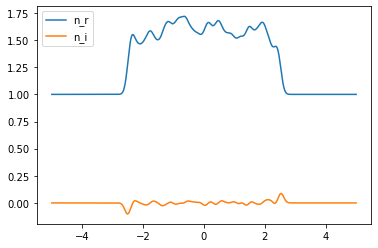

In [81]:
x = np.arange(-5,5,0.001)
dx = x[1] - x[0]

W = generate_W(x)
dW = diff_W(W)

plot_n(x, W, dW,k)

### Berechne aus W und n die Wellenfunktion mit Numerov

$\psi'' + k^2 n^2 \psi = 0$

Der iterative Algorithmus sieht dann so aus:

$s := \frac{h^2 k^2}{12} $

$\psi_{i+2} = \frac{ 2(1 - 5 s n_{i+1}^2)\psi_{i+1} - (1 + s n_{i+1}^2)\psi_{i} }{1 + s n_{i+2}^2}  $

In [82]:
def Numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1,k):
    
    psi = np.zeros(len(x), dtype=complex)
    psi[0] = complex(psi_r0, psi_i0) #Startwerte
    psi[1] = complex(psi_r1, psi_i1)
    
    s = dx**2/12 * k**2
    
    for i in range(len(x)-2):
                
        psi[i+2] = ( 2*( 1-5*s*n[i+1]**2 )*psi[i+1] - ( 1+s*n[i+1]**2 )*psi[i] )/(1 +  s*n[i+2]**2)
        
    return psi

Für die Startwerte müssen wir außerdem eine ebene Welle generieren:

In [83]:
def InitV_In(x, dx, k, A):
    
    psi = np.zeros(len(x), dtype=complex)
    
    for i in range(len(x)):
        psi[i] = A * np.cos(x[i]*k) + 1j * A * np.sin(x[i]*k) 
        
    #pylab.plot(x[:ldt], psi.real, label='psi real') 
    #pylab.plot(x[:ldt], psi.imag, label='psi imag')
    
    return psi[0].real, psi[1].real, psi[0].imag, psi[1].imag

In [84]:
def plot_psi(x, dx, n, Amp, k):

    #n = n_compl(W,dW,x,k)
    
    #psi_r0, psi_r1, psi_i0, psi_i1 = InitV_Left(t,dt,k, Amp, n)
    psi_r0, psi_r1, psi_i0, psi_i1 = InitV_In(x,dx,k, Amp)
    
    psi = Numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1, k)
    
    f = len(x)
    
    pylab.plot(x[-f:],psi.real[-f:],label='psi real')
    pylab.plot(x[-f:],psi.imag[-f:],label='psi imag')
    
    pylab.plot(x[-f:], n.real[-f:], label = 'nr')
    pylab.plot(x[-f:], n.imag[-f:], label = 'ni')
    
    Int = psi.real**2 + psi.imag**2
    
    pylab.plot(x[-f:], Int[-f:], label = 'Intensity')
        
    pylab.legend(loc='upper left')

In [85]:
W = generate_W(x)
dW = diff_W(W)
n = n_compl(W,dW,x,k)

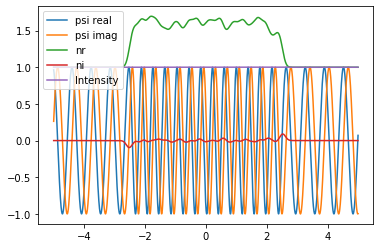

In [86]:
plot_psi(x, dx, n, 1, k)

### Berechne Abweichung von konstanter Intensität

In [87]:
def MSE(Int, Amp):
    return sum((Int-Amp)**2)

In [88]:
Amp = 1

n = n_compl(W,dW,x,k)
psi_r0, psi_r1, psi_i0, psi_i1 = InitV_In(x,dx,k, Amp)
psi = Numerov(x, dx, n, psi_r0, psi_r1, psi_i0, psi_i1, k)
Int = psi.real**2 + psi.imag**2

MSE(Int,Amp)

0.004458614156764522

### Daten generieren

Wir generieren und speichern eine Menge an $n_r$ und $n_i$ Paaren.

In [89]:
#so wurde das Dataset1, in dem verschiedene k Werte vorkommen, generiert!
out = 'data/'

x = np.arange(-5,5,0.001)
dx = x[1] - x[0]

size = 5000

In [245]:
#so wurde das Dataset1, in dem verschiedene k Werte vorkommen, generiert!
Potentials = {}
Potentials['idx'] = []
Potentials['k'] = []

start = time.time()
last = time.time()

for i in range(size):

    if i%100 == 0: 
        so_far = time.time() - start
        since_last = time.time() - last
        last = time.time()
        print('Generating Pot Nmbr ',i, ', Runtime since last: ', since_last, ', Runtime so far: ', so_far)
        
    
    k = np.random.randint(1,11, size=1)[0]
    
    W = generate_W(x)
    dW = diff_W(W)
    
    n = n_compl(W,dW,x,k)
    
    np.save(out + 'n_real_' + str(i), n.real)
    np.save(out + 'n_imag_' + str(i), n.imag)
    Potentials['idx'].append(i)
    Potentials['k'].append(k)
    
df = pd.DataFrame(Potentials, columns= ['idx', 'k'])

export_csv = df.to_csv (r''+out+'k_values.csv', index = None, header=True)

df.head()

Generating Pot Nmbr  0 , Runtime since last:  0.0001513957977294922 , Runtime so far:  0.00017142295837402344
Generating Pot Nmbr  100 , Runtime since last:  19.134867429733276 , Runtime so far:  19.13503909111023
Generating Pot Nmbr  200 , Runtime since last:  19.3423273563385 , Runtime so far:  38.47736644744873
Generating Pot Nmbr  300 , Runtime since last:  19.526109218597412 , Runtime so far:  58.00347685813904
Generating Pot Nmbr  400 , Runtime since last:  19.24662971496582 , Runtime so far:  77.25010657310486
Generating Pot Nmbr  500 , Runtime since last:  18.881889820098877 , Runtime so far:  96.1319968700409
Generating Pot Nmbr  600 , Runtime since last:  18.70429491996765 , Runtime so far:  114.8362922668457
Generating Pot Nmbr  700 , Runtime since last:  18.551145315170288 , Runtime so far:  133.38743829727173
Generating Pot Nmbr  800 , Runtime since last:  18.539689540863037 , Runtime so far:  151.92712831497192
Generating Pot Nmbr  900 , Runtime since last:  18.5118951797

,idx,k
0,0,2
1,1,2
2,2,5
3,3,6
4,4,9


In [20]:
#so wurde das Dataset2, in dem nur ein k Werte vorkommt, generiert!
out = 'data2/'

sample_length = 2**13
low = -5
up = 5
dx = (up-low)/sample_length
x = np.arange(low,up,dx)

size = int(len(x)/2)

4096

In [ ]:
#so wurde das Dataset2, in dem nur ein k Werte vorkommt, generiert!
Potentials = {}
Potentials['idx'] = []
Potentials['k'] = []

start = time.time()
last = time.time()

for i in range(size):

    if i%100 == 0: 
        so_far = time.time() - start
        since_last = time.time() - last
        last = time.time()
        print('Generating Pot Nmbr ',i, ', Runtime since last: ', since_last, ', Runtime so far: ', so_far)
        
    
    k = 1 #np.random.randint(1,11, size=1)[0]
    
    W = generate_W(x)
    dW = diff_W(W)
    
    n = n_compl(W,dW,x,k)
    
    np.save(out + 'n_real_' + str(i), n.real)
    np.save(out + 'n_imag_' + str(i), n.imag)
    Potentials['idx'].append(i)
    Potentials['k'].append(k)
    
df = pd.DataFrame(Potentials, columns= ['idx', 'k'])

export_csv = df.to_csv (r''+out+'k_values.csv', index = None, header=True)

df.head()

575


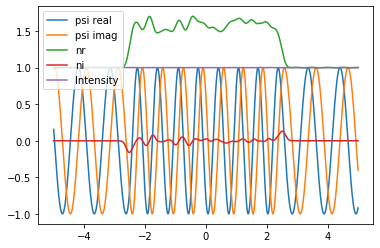

In [90]:
#test ob es funktioniert hat

df = pd.read_csv(out + '/k_values.csv')

idx = np.random.randint(size, size=1)[0]
print(idx)

k = df['k'][idx]

nr = np.load(out + 'n_real_' + str(idx) + '.npy')
ni = np.load(out + 'n_imag_' + str(idx) +'.npy')
n = nr + 1j*ni
plot_psi(x, dx, n, 1, k)

Ein Element aus unserem Dataset wird ein Dictionary sein, mit folgenden Werten:

    {
    'k_n_r': 1_dim Array (k, n_r),
    'n_i': 1_dim Array
    }

Wir erzeugen eine Klasse, von der ein Dataset ein Objekt sein wird. 

In [91]:
class PotentialDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.k_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.k_frame)
    
    def __getitem__(self, idx):
        nr = np.load(out + 'n_real_' + str(idx) +'.npy')
        ni = np.load(out + 'n_imag_' + str(idx) +'.npy')
        k = self.k_frame['k'][idx]
        
        k_nr = np.append(k,nr)
        
        sample = {'k_n_r': k_nr, 
                  'n_i': ni}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [92]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        k_nr, ni = sample['k_n_r'], sample['n_i']
        
        return {'k_n_r': torch.from_numpy(k_nr).float().to(device),
                'n_i': torch.from_numpy(ni).float().to(device)}

In [93]:
class OneChannel(object):
    """For Convolution, size (N,C,L) is needed"""
    
    def __call__(self, sample):
        new_samp = {'k_n_r': torch.ones([1,len(sample['k_n_r'])]),
                    'n_i': torch.ones([1,len(sample['n_i'])])}
        new_samp['k_n_r'][0] = sample['k_n_r']
        new_samp['n_i'][0] = sample['n_i']
        new_samp['k_n_r'] = new_samp['k_n_r'].to(device)
        new_samp['n_i'] = new_samp['n_i'].to(device)
        
        return new_samp

In [94]:
class Normalize(object):
    """"Data ist then normalized to given mean and std."""

    def __init__(self, means, stds):
        self.nr_mean = means[0]
        self.nr_std = stds[0]
        self.ni_mean = means[1]
        self.ni_std = stds[1]
    
    def __call__(self, sample):
        k_nr, ni = sample['k_n_r'], sample['n_i']
        
        k_nr = (k_nr - self.nr_mean)/self.nr_std
        ni = (ni - self.ni_mean)/self.ni_std
        
        return {'k_n_r': k_nr,
                'n_i': ni}

Erzeuge das Objekt Dataset.

In [95]:
# calculate mean and std of data (vernachlässige k)

nr_mean = 0
nr_std = 0
ni_mean = 0
ni_std = 0

for i in range(size):
    nr = np.load(out + 'n_real_' + str(i) + '.npy')
    ni = np.load(out + 'n_imag_' + str(i) + '.npy')
    
    nr_mean += np.mean(nr)
    nr_std += np.std(nr)
    ni_mean += np.mean(ni)
    ni_std += np.std(ni)
    
nr_mean = nr_mean/size
nr_std = nr_std/size
ni_mean = ni_mean/size
ni_std = ni_std/size

In [96]:
transform = transforms.Compose([Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
                                ToTensor()
                               ])

Lege Tensoren auf CUDA.

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [98]:
pot_dataset = PotentialDataset(csv_file = out + 'k_values.csv', 
                               root_dir = out,
                               transform = transform)

In [99]:
pot_dataset[19]['k_n_r'][0] #funktioniert prima

tensor(29.4336, device='cuda:0')

In [100]:
print(pot_dataset[19]['k_n_r'].size())

torch.Size([10001])


In [101]:
pot_dataset[19]['k_n_r'].is_cuda

True

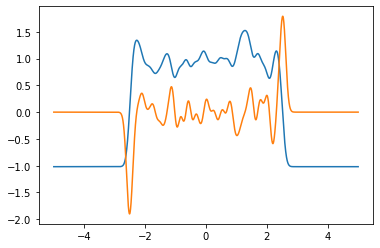

In [102]:
pylab.plot(x,pot_dataset[19]['k_n_r'].cpu().numpy()[1:])
pylab.plot(x,pot_dataset[19]['n_i'].cpu().numpy())

### Trainiere Netz

Erstelle einen Train/Validation Split und die zugehörigen PyTorch DataLoader.

In [103]:
batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(pot_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size)) #floor tut abrunden
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(pot_dataset, 
                          batch_size=batch_size, 
                          sampler=train_sampler)
validation_loader = DataLoader(pot_dataset, 
                               batch_size=batch_size,
                               sampler=valid_sampler)

Erstelle ein Fully Connected Feed Forward Net.

In [104]:
class Net(nn.Module):

    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.hidden3 = nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = nn.Linear(n_hidden, n_output) # output layer        

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.predict(x)             # linear output
        return x

In [ ]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

PATH = 'models/FNN.pt'

model = torch.load(PATH)
model.eval()

In [105]:
#sonst erstelle jetzt neues Netz

model = Net(n_feature=10001, n_hidden=1000, n_output=10000)
print(model)

Net(
  (hidden1): Linear(in_features=10001, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=1000, bias=True)
  (hidden3): Linear(in_features=1000, out_features=1000, bias=True)
  (predict): Linear(in_features=1000, out_features=10000, bias=True)
)


Model auf CUDA:

In [106]:
model.to(device)

Net(
  (hidden1): Linear(in_features=10001, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=1000, bias=True)
  (hidden3): Linear(in_features=1000, out_features=1000, bias=True)
  (predict): Linear(in_features=1000, out_features=10000, bias=True)
)

In [107]:
next(model.parameters()).is_cuda

True

Definiere Optimizer und Loss Function.

In [108]:
learning_rate = 1e-3

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Jetzt beginnt das echte Training.

In [109]:
num_epochs = 20
train_loss = [] #Lists für Plot
validation_loss = []

# Initialisiere Visdom Loss Monitor
vis = visdom.Visdom()

#erste Punkte mit ursprünglichen Loss Werten
train_loss_ep = 0 
for i, data in enumerate(train_loader):
    k_nr = data['k_n_r']
    ni = data['n_i']
    ni_pred = model(k_nr)
    train_loss_ep += criterion(ni_pred,ni).item() / len(train_loader)
    
validation_loss_ep = 0
for i, data in enumerate(validation_loader):
    k_nr = data['k_n_r']
    ni = data['n_i']
    ni_pred = model(k_nr)
    validation_loss_ep += criterion(ni_pred,ni).item() / len(validation_loader)

#initialisiere die beiden Loss Lines in Visdom mit ersten Punkten
vis_loss_plt= vis.line(
    X=np.column_stack((0, 0)),
    Y=np.column_stack((train_loss_ep, validation_loss_ep)),
    opts = {
    'title': 'Loss Potential-Dataset',
    'legend': ['train','validation']}
)

#fülle Listen für Matplolib Plot zum Schluss mit ersten Punkten
train_loss.append(train_loss_ep)
validation_loss.append(validation_loss_ep)

# Variablen für Zeit - Messung
ts = time.time()

#######################################################
# Ab hier bis zu Hashs geht das eigentliche Training!
#######################################################

running_loss = 0.0 #loss zum mitschreiben nach den Batches

for ep in range(num_epochs): #loop for some episodes
    
    model = model.train() #pytorch training mode
    
    for i, data in enumerate(train_loader): #iterate trough minibatches of training set
        
        k_nr = data['k_n_r']
        ni = data['n_i']
        
        # Forward pass: Compute predicted y by passing x to the model
        ni_pred = model(k_nr)

        # Compute and print loss
        loss = criterion(ni_pred, ni)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item() * k_nr.size(0)
        if i % 10 == 0:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f runtime: %f' %
                  (ep + 1, i + 1, running_loss / 10, time.time() - ts))
            running_loss = 0.0
            
#######################################################
# Ab jetzt nur mehr Plots etc
#######################################################  

    model = model.eval() #pytorch evaluation mode
    
    # print learning curve with visdom
    train_loss_ep = 0 #ermittle loss von gesamten train/val dataset
    for i, data in enumerate(train_loader):
        k_nr = data['k_n_r']
        ni = data['n_i']
        ni_pred = model(k_nr)
        train_loss_ep += criterion(ni_pred,ni).item() / len(train_loader)
    
    validation_loss_ep = 0
    for i, data in enumerate(validation_loader):
        k_nr = data['k_n_r']
        ni = data['n_i']
        ni_pred = model(k_nr)
        validation_loss_ep += criterion(ni_pred,ni).item() / len(validation_loader)
    
    #füge einen punkt in visdom hinzu
    vis.line(
        X=np.column_stack((ep+1, ep+1)),
        Y=np.column_stack((train_loss_ep,
                           validation_loss_ep )),
        win=vis_loss_plt,
        update='append'
    )
    
    # save losses for final loss plot
    train_loss.append(train_loss_ep)
    validation_loss.append(validation_loss_ep)

[1,     1] loss: 0.596 runtime: 0.014844
[1,    11] loss: 12.984 runtime: 0.133401
[1,    21] loss: 7.189 runtime: 0.253112
[1,    31] loss: 8.703 runtime: 0.373328
[1,    41] loss: 7.962 runtime: 0.491968
[1,    51] loss: 5.962 runtime: 0.618685
[1,    61] loss: 6.398 runtime: 0.741970
[1,    71] loss: 5.123 runtime: 0.866718
[1,    81] loss: 5.564 runtime: 0.995924
[1,    91] loss: 4.802 runtime: 1.114211
[1,   101] loss: 3.719 runtime: 1.233078
[1,   111] loss: 3.827 runtime: 1.351695
[1,   121] loss: 5.490 runtime: 1.481419
[1,   131] loss: 4.447 runtime: 1.602486
[1,   141] loss: 5.827 runtime: 1.727470
[1,   151] loss: 3.986 runtime: 1.853616
[1,   161] loss: 3.541 runtime: 1.982857
[1,   171] loss: 4.904 runtime: 2.110685
[1,   181] loss: 5.524 runtime: 2.232966
[1,   191] loss: 4.550 runtime: 2.353976
[1,   201] loss: 4.823 runtime: 2.475796
[1,   211] loss: 3.671 runtime: 2.606994
[1,   221] loss: 5.308 runtime: 2.730360
[1,   231] loss: 4.394 runtime: 2.874292
[1,   241] loss

[4,   481] loss: 4.660 runtime: 36.037520
[4,   491] loss: 3.427 runtime: 36.167462
[5,     1] loss: 3.170 runtime: 40.085931
[5,    11] loss: 3.290 runtime: 40.204638
[5,    21] loss: 3.897 runtime: 40.324839
[5,    31] loss: 2.660 runtime: 40.455624
[5,    41] loss: 3.706 runtime: 40.601912
[5,    51] loss: 5.582 runtime: 40.741586
[5,    61] loss: 4.919 runtime: 40.876374
[5,    71] loss: 3.023 runtime: 41.013035
[5,    81] loss: 4.494 runtime: 41.137705
[5,    91] loss: 4.455 runtime: 41.263551
[5,   101] loss: 4.416 runtime: 41.385697
[5,   111] loss: 3.714 runtime: 41.505911
[5,   121] loss: 4.558 runtime: 41.626539
[5,   131] loss: 4.596 runtime: 41.762028
[5,   141] loss: 2.791 runtime: 41.898524
[5,   151] loss: 3.721 runtime: 42.029742
[5,   161] loss: 2.566 runtime: 42.153842
[5,   171] loss: 2.960 runtime: 42.283489
[5,   181] loss: 3.629 runtime: 42.431582
[5,   191] loss: 2.318 runtime: 42.576980
[5,   201] loss: 3.046 runtime: 42.702705
[5,   211] loss: 3.739 runtime: 42

[8,   441] loss: 2.888 runtime: 75.744102
[8,   451] loss: 3.380 runtime: 75.874815
[8,   461] loss: 3.930 runtime: 75.997783
[8,   471] loss: 4.100 runtime: 76.136887
[8,   481] loss: 3.958 runtime: 76.279229
[8,   491] loss: 3.867 runtime: 76.412145
[9,     1] loss: 3.145 runtime: 80.484770
[9,    11] loss: 3.384 runtime: 80.624775
[9,    21] loss: 3.891 runtime: 80.755948
[9,    31] loss: 4.559 runtime: 80.888060
[9,    41] loss: 3.640 runtime: 81.007944
[9,    51] loss: 2.917 runtime: 81.128080
[9,    61] loss: 2.959 runtime: 81.246813
[9,    71] loss: 2.152 runtime: 81.375847
[9,    81] loss: 4.439 runtime: 81.504621
[9,    91] loss: 4.176 runtime: 81.621320
[9,   101] loss: 4.296 runtime: 81.740871
[9,   111] loss: 2.793 runtime: 81.860159
[9,   121] loss: 4.383 runtime: 81.979882
[9,   131] loss: 2.424 runtime: 82.099009
[9,   141] loss: 2.689 runtime: 82.223991
[9,   151] loss: 3.779 runtime: 82.349734
[9,   161] loss: 2.976 runtime: 82.492287
[9,   171] loss: 4.277 runtime: 82

[12,   341] loss: 2.379 runtime: 115.167108
[12,   351] loss: 3.632 runtime: 115.286965
[12,   361] loss: 2.768 runtime: 115.418667
[12,   371] loss: 3.987 runtime: 115.547901
[12,   381] loss: 4.345 runtime: 115.667351
[12,   391] loss: 2.411 runtime: 115.791456
[12,   401] loss: 2.912 runtime: 115.936427
[12,   411] loss: 3.855 runtime: 116.063650
[12,   421] loss: 2.210 runtime: 116.184617
[12,   431] loss: 3.210 runtime: 116.301462
[12,   441] loss: 3.715 runtime: 116.422017
[12,   451] loss: 3.035 runtime: 116.559096
[12,   461] loss: 2.505 runtime: 116.683567
[12,   471] loss: 2.739 runtime: 116.804935
[12,   481] loss: 1.680 runtime: 116.931158
[12,   491] loss: 3.250 runtime: 117.057199
[13,     1] loss: 3.984 runtime: 120.973468
[13,    11] loss: 3.520 runtime: 121.091670
[13,    21] loss: 3.853 runtime: 121.210926
[13,    31] loss: 2.334 runtime: 121.329760
[13,    41] loss: 1.847 runtime: 121.449835
[13,    51] loss: 3.774 runtime: 121.565608
[13,    61] loss: 3.348 runtime:

[16,   221] loss: 3.652 runtime: 153.913886
[16,   231] loss: 3.462 runtime: 154.031694
[16,   241] loss: 5.241 runtime: 154.151636
[16,   251] loss: 4.880 runtime: 154.274467
[16,   261] loss: 2.941 runtime: 154.399983
[16,   271] loss: 1.957 runtime: 154.527581
[16,   281] loss: 2.868 runtime: 154.650623
[16,   291] loss: 3.539 runtime: 154.770887
[16,   301] loss: 4.929 runtime: 154.894367
[16,   311] loss: 2.784 runtime: 155.018299
[16,   321] loss: 3.838 runtime: 155.136113
[16,   331] loss: 3.898 runtime: 155.262626
[16,   341] loss: 2.636 runtime: 155.384540
[16,   351] loss: 2.440 runtime: 155.506105
[16,   361] loss: 3.667 runtime: 155.635638
[16,   371] loss: 3.495 runtime: 155.755861
[16,   381] loss: 3.085 runtime: 155.877233
[16,   391] loss: 3.517 runtime: 155.999904
[16,   401] loss: 3.079 runtime: 156.133581
[16,   411] loss: 1.950 runtime: 156.257857
[16,   421] loss: 2.851 runtime: 156.384216
[16,   431] loss: 2.389 runtime: 156.508084
[16,   441] loss: 4.225 runtime:

[20,   101] loss: 3.699 runtime: 193.696090
[20,   111] loss: 3.372 runtime: 193.813849
[20,   121] loss: 4.147 runtime: 193.932171
[20,   131] loss: 3.482 runtime: 194.048903
[20,   141] loss: 3.619 runtime: 194.182945
[20,   151] loss: 2.029 runtime: 194.328474
[20,   161] loss: 4.708 runtime: 194.465357
[20,   171] loss: 3.043 runtime: 194.586323
[20,   181] loss: 2.577 runtime: 194.715212
[20,   191] loss: 3.234 runtime: 194.854910
[20,   201] loss: 3.752 runtime: 195.000113
[20,   211] loss: 3.086 runtime: 195.121562
[20,   221] loss: 3.030 runtime: 195.256279
[20,   231] loss: 3.222 runtime: 195.389305
[20,   241] loss: 4.613 runtime: 195.519180
[20,   251] loss: 4.027 runtime: 195.657353
[20,   261] loss: 3.620 runtime: 195.808642
[20,   271] loss: 2.359 runtime: 195.951194
[20,   281] loss: 5.459 runtime: 196.093609
[20,   291] loss: 3.106 runtime: 196.217669
[20,   301] loss: 3.203 runtime: 196.365436
[20,   311] loss: 2.974 runtime: 196.504499
[20,   321] loss: 3.001 runtime:

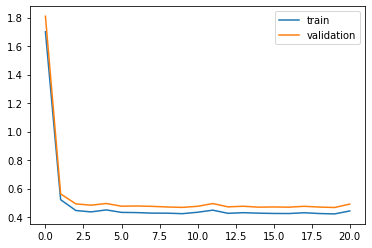

In [110]:
# final loss plot
pylab.plot(train_loss,label='train')
pylab.plot(validation_loss,label='validation')
pylab.legend(loc='upper right')
pylab.show()

# Im Unterschied zum Visdom-Plot ist hier kein untrainerter Loss-Punkt geplottet

### Prüfe Predictions

Wir wollen noch für ein Objekt Prediction vs Label plotten.

In [111]:
#Rücktrafo weil Daten ja normalisiert sind

def DeNorm(x,mean,std):
    y = x*std + mean
    return y

6.000000034989653


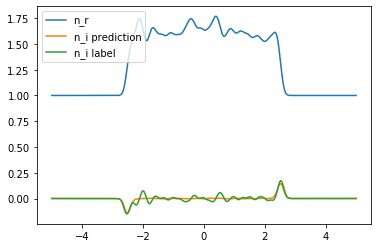

In [118]:
dataiter = iter(validation_loader)
item = dataiter.next()

k_nr = item['k_n_r'][0]
k = DeNorm(k_nr[0].cpu().numpy(), nr_mean, nr_std)

nr = k_nr[1:].cpu().numpy()
nr = DeNorm(nr, nr_mean, nr_std)
ni = item['n_i'][0].cpu().numpy()
ni = DeNorm(ni, ni_mean, ni_std)

ni_pred = model(k_nr).detach().cpu().numpy()
ni_pred = DeNorm(ni_pred, ni_mean, ni_std)

print(k) #höherer k Value führt zu kleinerem Peak von ni

pylab.plot(x,nr,label='n_r')
pylab.plot(x,ni_pred,label='n_i prediction')
pylab.plot(x,ni,label='n_i label')
pylab.legend(loc='upper left')
pylab.savefig('FNN Prediction.pdf')

Plotte jetzt noch die Wellen.

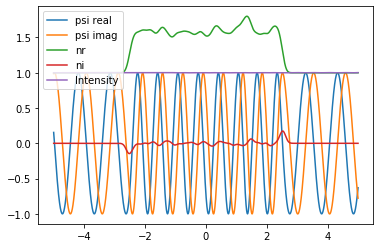

In [114]:
n = nr + 1j*ni

plot_psi(x, dx, n, 1, k) # Amplitude = 1

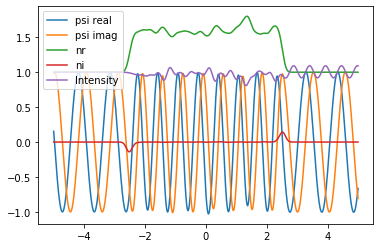

In [115]:
n_pred = nr + 1j*ni_pred

plot_psi(x, dx, n_pred, 1, k)

### Save Model

In [116]:
PATH = 'models/FNN.pt'

In [117]:
torch.save(model, PATH)

/home/felixwagner/miniconda3/envs/felix_ml/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Nützliches eventuell für Später


Außerdem wollen wir den MSE brechnen, wie sehr n_i und die prediction punktweise abweichen und die Prediction dann als "richtig" oder "falsch" detulieren. 

In [40]:
def MSE_Difference(ni,ni_pred):
    if len(ni) != len (ni_pred):
        print('label and prediction must have same size!')
    else:
        err = 0
        for (i,j) in zip(ni, ni_pred):
            err += (i-j)**2
        err = err/len(ni)
        return err

In [43]:
MSE_Difference(ni, ni_pred)

0.0001356436968946423

Und hier soll noch der MSE der resultierenden Welle berechnet werden und die Welle geplottet. Der MSE sollte jedenfalls kleiner 1 sein, wenn die prediction korrekt ist.

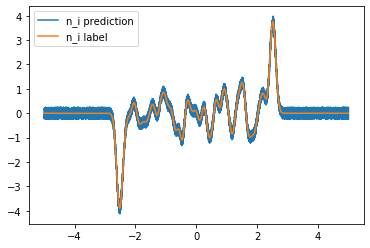

0.020781679725574317

In [20]:
# hier ein Test, wie hoch der MSE ist für leicht verrauschte Daten
# mt einem MSE von 0.02 muss man scheinbar immer rechnen


ni_noise = np.copy(ni.detach().numpy())
noise_range = 0.5
for i in range(len(ni_noise)):
    ni_noise[i] +=  np.random.uniform()*noise_range - noise_range/2

pylab.plot(x,ni_noise,label='n_i prediction')
pylab.plot(x,ni.numpy(),label='n_i label')
pylab.legend(loc='upper left')
pylab.show()
MSE_Difference(ni.detach().numpy(), ni_noise)

In [47]:
#Fourier transformiere n

def FFT_n(n,x):
    nrf = 2.0/len(x) * np.abs(fft(n.real)[0:len(x)//2])
    nif = 2.0/len(x) * np.abs(fft(n.imag)[0:len(x)//2])
    xf = np.linspace(0.0, 1.0/(2.0*dx), len(x)//2)
    return nrf, nif, xf

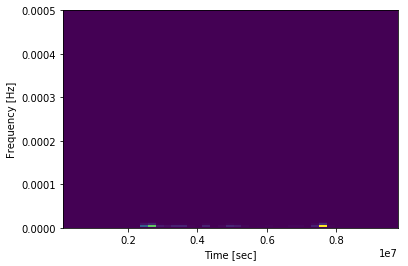

In [55]:
#spectrogram plot von n

fs = 10/len(x)

f, t, Sxx = signal.spectrogram(n.real, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()